In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import os

In [2]:
path_to_dataset = "D:\\youtube_faces\\data_faces\\YouTubeFaces"
path_to_imgs = os.path.join(path_to_dataset, "frame_images_DB")

In [3]:
dict_of_frames_pers = {}
dict_of_frames_vd = {}

In [4]:
for person in os.listdir(path_to_imgs):
    if ".txt" in person:
        continue
    path_to_person = os.path.join(path_to_imgs, person)

    pers_counter = 0
    for video in os.listdir(path_to_person):
        path_to_frames = os.path.join(path_to_person, video)
        len_of_vid = len(os.listdir(path_to_frames))
        
        dict_of_frames_vd[path_to_frames] = len_of_vid
        pers_counter += len_of_vid
    dict_of_frames_pers[person] = pers_counter

Number of people: 1595
Min: 48 frames
Max: 6070 frames
Mean: 389.4 frames
Median: 226.0 frames
STD: 510.6


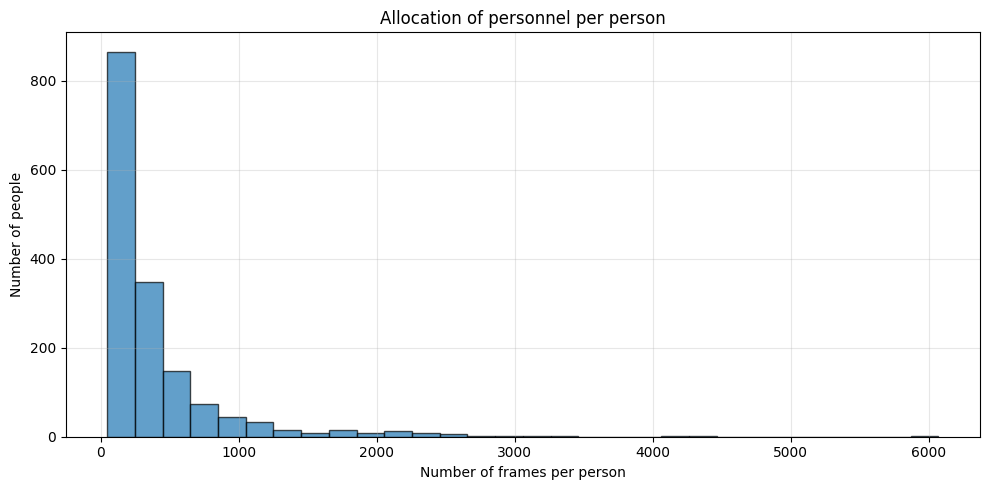

In [5]:
frames_per_person = list(dict_of_frames_pers.values())

print(f"Number of people: {len(frames_per_person)}")
print(f"Min: {np.min(frames_per_person)} frames")
print(f"Max: {np.max(frames_per_person)} frames")
print(f"Mean: {np.mean(frames_per_person):.1f} frames")
print(f"Median: {np.median(frames_per_person):.1f} frames")
print(f"STD: {np.std(frames_per_person):.1f}")

plt.figure(figsize=(10, 5))

n, bins, patches = plt.hist(frames_per_person, bins=30, 
                           edgecolor='black', alpha=0.7)
plt.xlabel('Number of frames per person')
plt.ylabel('Number of people')
plt.title('Allocation of personnel per person')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Number of videos: 3425
Min: 48 frames
Max: 2157 frames
Mean: 181.4 frames
Median: 93.0 frames
STD: 268.6


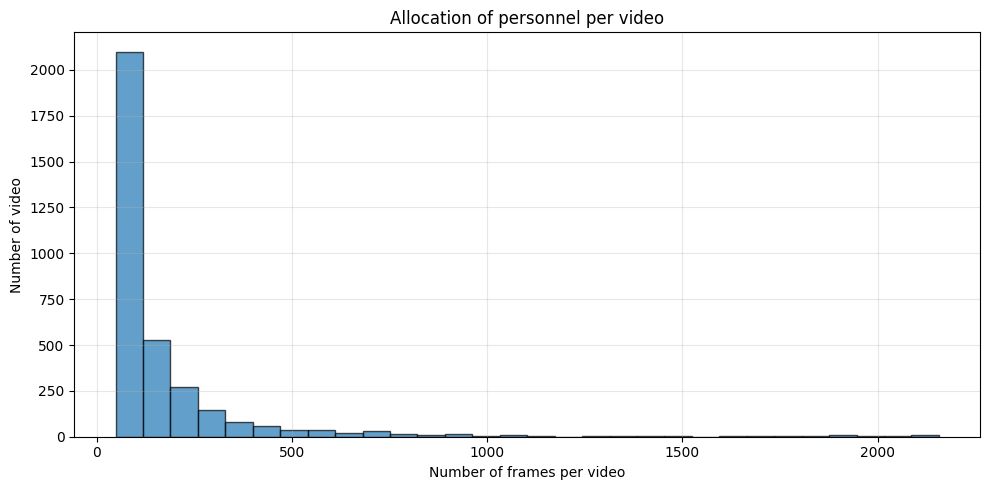

In [6]:
frames_per_vid = list(dict_of_frames_vd.values())

print(f"Number of videos: {len(frames_per_vid)}")
print(f"Min: {np.min(frames_per_vid)} frames")
print(f"Max: {np.max(frames_per_vid)} frames")
print(f"Mean: {np.mean(frames_per_vid):.1f} frames")
print(f"Median: {np.median(frames_per_vid):.1f} frames")
print(f"STD: {np.std(frames_per_vid):.1f}")

plt.figure(figsize=(10, 5))

n, bins, patches = plt.hist(frames_per_vid, bins=30, 
                           edgecolor='black', alpha=0.7)
plt.xlabel('Number of frames per video')
plt.ylabel('Number of video')
plt.title('Allocation of personnel per video')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
"Aaron_Eckhart\\0\\0.555.jpg,0,237,137,84,84,0.0,1".split(",")

['Aaron_Eckhart\\0\\0.555.jpg', '0', '237', '137', '84', '84', '0.0', '1']

In [8]:
path_to_imgs

'D:\\youtube_faces\\data_faces\\YouTubeFaces\\frame_images_DB'

In [9]:
someone = [path for path in os.listdir(path_to_imgs) if ".txt" in path][0]
path_to_someone = os.path.join(path_to_imgs, someone)
with open(path_to_someone) as f:
    a = f.read().strip().split("\n")
a[0].split("\\")

['Aaron_Eckhart', '0', '0.555.jpg,0,237,137,84,84,0.0,1']

In [10]:
from random import randint
from pathlib import Path
class Seq2SeqDataset(torch.utils.data.Dataset):
    def __init__(self, *, train=True, seed=42):
        self.root = Path(path_to_imgs)

        assert self.root.is_dir(), f"No data at `{path_to_imgs}`"

        meta = [path for path in os.listdir(self.root) if ".txt" in path]
        list_of_filenames_per_person = []
        list_of_bboxes_per_person = []

        for person_id, meta_name in enumerate(meta):
            list_of_bboxes_of_videos = []
            list_of_filenames_of_videos = []
            
            meta_path = os.path.join(self.root, meta_name)
            with open(meta_path) as f:
                meta_txt = f.read().strip().split("\n")
            if meta_txt == ['']:
                continue
            filenames_to_vid = [meta_txt[0].split(",")[0]]
            bbox_to_vid = [list(map(int, meta_txt[0].split(",")[2:6]))]

            video_id_writing = meta_txt[0].split("\\")[1]

            
            
            for i in range(1, len(meta_txt)):
                video_id_current = meta_txt[i].split("\\")[1]
                if video_id_current != video_id_writing:
                    # if len(bbox_to_vid) == 1:
                    #     print(filenames_to_vid)
                    list_of_bboxes_of_videos.append(bbox_to_vid)
                    list_of_filenames_of_videos.append(filenames_to_vid)
                    video_id_writing = video_id_current
                    bbox_to_vid = []
                    filenames_to_vid = []

                filename_of_frame = meta_txt[i].split(",")[0]
                filenames_to_vid.append(filename_of_frame)
                
                bbox_info = list(map(int, meta_txt[i].split(",")[2:6]))
                bbox_to_vid.append(bbox_info)
            if len(bbox_to_vid) == 1:
                print(filenames_to_vid)
            list_of_bboxes_of_videos.append(bbox_to_vid)        
            list_of_bboxes_per_person.append(list_of_bboxes_of_videos)

            list_of_filenames_of_videos.append(filenames_to_vid)
            list_of_filenames_per_person.append(list_of_filenames_of_videos)
            
            # list_of_persons[list_of_videos[list_of_bboxes[ ... ] ] ]
            # list_of_persons[list_of_videos[list_of_filenames[ ... ] ] ]

        self.data = [{"bboxes": list_of_bboxes_per_person[i], "filenames": list_of_filenames_per_person[i]} 
                      for i in range(len(list_of_filenames_per_person))]
        np.random.seed(seed)
        permutation = np.random.permutation(len(self.data)).tolist()

        # Train/test split
        if train:
            self.data = [self.data[i] for i in
                permutation[: int(len(self.data) * 0.85)]
            ]
        else:
            self.data = [self.data[i] for i in
                permutation[int(len(self.data) * 0.85) :]
            ]
        
        self.data = [ {"bboxes": self.data[i]['bboxes'][j], 
                       "filename": self.data[i]['filenames'][j]}
            for i in range(len(self.data)) for j in range(len(self.data[i]['bboxes']))
        ]
    def __getitem__(self, idx, nmax=15, kmax=10):

        curr_data = self.data[idx]
        amount_of_frames = len(curr_data['bboxes'])
        N = randint(15, 25)
        K = randint(5, 15)
        if amount_of_frames < (N + K):
            print(idx, curr_data)
        start = randint(0, amount_of_frames - (N + K))

        fname = curr_data['filename']
        bboxes = curr_data['bboxes']
               
        input_bboxes = bboxes[start: start + N]
        target_bboxes = bboxes[start + N : start + N + K]
        fnames_input = fname[start : start + N]
        fnames_target = fname[start + N: start + N + K]

        return {"input": input_bboxes, "target": target_bboxes,
                "filenames": {"input": fnames_input, "target": fnames_target}}
    def __len__(self):
        return len(self.data)

In [11]:
train_data = Seq2SeqDataset(train=True)
test_data = Seq2SeqDataset(train=False)

In [12]:
len(train_data)

2914

In [13]:
train_data[0]

{'input': [[158, 116, 66, 66],
  [157, 116, 66, 66],
  [157, 115, 67, 67],
  [157, 115, 67, 67],
  [158, 115, 66, 66],
  [158, 115, 66, 66],
  [158, 115, 69, 69],
  [158, 116, 68, 68],
  [157, 115, 67, 67],
  [157, 115, 67, 67],
  [158, 115, 64, 64],
  [157, 114, 65, 65],
  [157, 114, 65, 65],
  [157, 115, 67, 67],
  [158, 115, 68, 68],
  [157, 114, 69, 69],
  [158, 115, 68, 68],
  [157, 115, 73, 73]],
 'target': [[158, 115, 70, 70],
  [159, 114, 68, 68],
  [158, 115, 67, 67],
  [158, 115, 67, 67],
  [157, 115, 65, 65],
  [158, 115, 68, 68],
  [157, 115, 67, 67],
  [158, 115, 69, 69],
  [158, 115, 69, 69],
  [157, 115, 68, 68],
  [157, 115, 68, 68],
  [157, 115, 67, 67],
  [158, 115, 68, 68],
  [158, 115, 68, 68],
  [159, 115, 68, 68]],
 'filenames': {'input': ['Leszek_Miller\\0\\0.545.jpg',
   'Leszek_Miller\\0\\0.546.jpg',
   'Leszek_Miller\\0\\0.547.jpg',
   'Leszek_Miller\\0\\0.548.jpg',
   'Leszek_Miller\\0\\0.549.jpg',
   'Leszek_Miller\\0\\0.550.jpg',
   'Leszek_Miller\\0\\0.551

In [14]:
len(train_data), len(test_data)

(2914, 511)

In [15]:

def visualize(images, bboxes):

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        image_path = images[i]
        all_path_to_image = os.path.join(path_to_imgs, image_path)
        image = Image.open(all_path_to_image)
        ax.imshow(image)

        xcenter, ycenter, w, h = bboxes[i]
        xmin = xcenter - w / 2
        ymin = ycenter - h / 2
        xmax = xcenter + w / 2
        ymax = ycenter + h / 2
        box_cls = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='blue')
        ax.add_patch(box_cls)

    fig.tight_layout()
    plt.show()

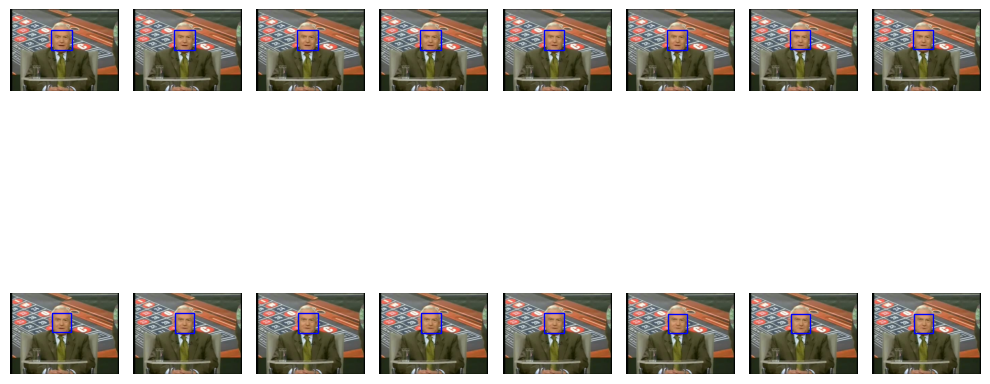

In [16]:
first_video = train_data[2]
bboxes = first_video['input']
images_path = first_video['filenames']['input']
visualize(images_path, bboxes)

In [18]:
import torch.nn as nn
class BBoxLoss(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.smooth_l1 = nn.SmoothL1Loss(beta=beta)

    def forward(self, pred, target):
        return self.smooth_l1(pred, target)
loss_fn = BBoxLoss()

In [40]:
def masked_loss(pred, target, pad_mask):

    raw_loss = nn.SmoothL1Loss(reduction='none')(pred, target)

    raw_loss = raw_loss.mean(dim=2)

    mask = ~pad_mask.transpose(0, 1)

    loss = raw_loss * mask.float()

    return loss.sum() / mask.sum()

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
from tqdm import tqdm

In [24]:
def collate_fn(batch):
    src_list = []
    tgt_in_list = []
    tgt_out_list = []

    for item in batch:
        src_coords = torch.tensor(item['input'], dtype=torch.float32)   # (N,4)
        tgt_coords = torch.tensor(item['target'], dtype=torch.float32)  # (K,4)

        first_img_rel_path = item['filenames']['input'][0]
        full_img_path = os.path.join(path_to_imgs, first_img_rel_path)

        with Image.open(full_img_path) as img:
            w, h = img.size

        scale = torch.tensor([w, h, w, h], dtype=torch.float32)

        norm_src = src_coords / scale
        norm_tgt = tgt_coords / scale

        # tgt_out: истинная последовательность
        tgt_out = norm_tgt  # (K,4)
        # tgt_in: [start_token; y0..y_{K-1}] -> длина K+1
        start = torch.zeros((1, 4), dtype=torch.float32)
        tgt_in = torch.cat([start, norm_tgt], dim=0)

        src_list.append(norm_src)
        tgt_in_list.append(tgt_in)
        tgt_out_list.append(tgt_out)

    from torch.nn.utils.rnn import pad_sequence

    src_batch = pad_sequence(src_list, batch_first=False, padding_value=0)      # (S_src,B,4)
    tgt_in_batch = pad_sequence(tgt_in_list, batch_first=False, padding_value=0)  # (S_tin,B,4)
    tgt_out_batch = pad_sequence(tgt_out_list, batch_first=False, padding_value=0) # (S_tout,B,4)

    src_pad = (src_batch.abs().sum(dim=2) == 0).transpose(0, 1)      # (B,S_src)
    tgt_in_pad = (tgt_in_batch.abs().sum(dim=2) == 0).transpose(0, 1)  # (B,S_tin)
    tgt_out_pad = (tgt_out_batch.abs().sum(dim=2) == 0).transpose(0, 1)

    # Возвращаем и вход, и таргет
    return src_batch, tgt_in_batch, tgt_out_batch, src_pad, tgt_in_pad, tgt_out_pad


In [22]:
train_loader = torch.utils.data.DataLoader(train_data, 512, collate_fn=collate_fn, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, 64, collate_fn=collate_fn, num_workers=0)

In [23]:
next(iter(train_loader))[0].shape

torch.Size([25, 512, 4])

In [49]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class Seq2SeqLSTMPredictor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=False
        )

        self.decoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=False
        )

        self.output = nn.Linear(hidden_dim, input_dim)

    def forward(self, src, tgt_in, src_pad_mask=None):
        src_lenghts = (~src_pad_mask).sum(dim=1).cpu()
        src_packed = pack_padded_sequence(src, src_lenghts, batch_first=False, enforce_sorted=False)
        
        
        _, (encoder_hidden, encoder_cell) = self.encoder(src_packed)

        decoder_output, _ = self.decoder(tgt_in, (encoder_hidden, encoder_cell))

        prediction = self.output(decoder_output)

        return prediction

In [91]:
def train_step_lstm(model, loader, loss_fn, optimizer):
    model.train()
    loss_arr = []
    for batch in tqdm(loader, desc="[train]: "):
        src, tgt_in, tgt_out, src_pad, tgt_in_pad, tgt_out_pad = batch
        src = src.to(device)
        tgt_in = tgt_in.to(device)
        tgt_out = tgt_out.to(device)
        src_pad = src_pad.to(device)
        tgt_in_pad = tgt_in_pad.to(device)
        tgt_out_pad = tgt_out_pad.to(device)
        # tgt_out_pad можно использовать, если хочется игнорировать pad в loss

        optimizer.zero_grad()

        pred = model(
            src,
            tgt_in,
            src_pad
        )  # (S_tin,B,4)

        # pred.shape: (S_tin,B,4), tgt_out: (S_tout,B,4)
        # S_tout = S_tin - 1 -> выравниваем
        pred = pred[1:, :, :]  # пропускаем первый timestep, соответствующий start-токену
        target = tgt_out

        loss = loss_fn(pred, target, tgt_out_pad)
        loss.backward()
        optimizer.step()

        loss_arr.append(loss.item())

    return sum(loss_arr) / len(loss_arr)


In [92]:
def test_step_lstm(model, loader, loss_fn):
    model.eval()
    loss_arr = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="[test]: "):
            src, tgt_in, tgt_out, src_pad, tgt_in_pad, tgt_out_pad = batch
            src = src.to(device)
            tgt_in = tgt_in.to(device)
            tgt_out = tgt_out.to(device)
            src_pad = src_pad.to(device)
            tgt_in_pad = tgt_in_pad.to(device)
            tgt_out_pad = tgt_out_pad.to(device)
            # tgt_out_pad можно использовать, если хочется игнорировать pad в loss
    
            pred = model(
                src,
                tgt_in,
                src_pad
            )  # (S_tin,B,4)
    
            # pred.shape: (S_tin,B,4), tgt_out: (S_tout,B,4)
            # S_tout = S_tin - 1 -> выравниваем
            pred = pred[1:, :, :]  # пропускаем первый timestep, соответствующий start-токену
            target = tgt_out
    
            loss = loss_fn(pred, target, tgt_out_pad)
    
            loss_arr.append(loss.item())

        return sum(loss_arr) / len(loss_arr)

In [112]:
def train_test_lstm(model, train_loader, test_loader, loss_fn, optimizer, scheduler, EPOCHS):
    train_loss_arr = []
    test_loss_arr = []
    best_test_loss = float('inf')
    patient = 0
    
    for epoch in tqdm(range(EPOCHS), desc="[EPOCHS]: "):
        train_lss = train_step_lstm(model, train_loader, loss_fn, optimizer)
        test_lss = test_step_lstm(model, test_loader, loss_fn)

        train_loss_arr.append(train_lss)
        test_loss_arr.append(test_lss)
        print(f"({epoch+1}/{EPOCHS}): train_lss - {train_lss: .6f}, test_lss - {test_lss: .6f}")

        scheduler.step(test_lss)
        if best_test_loss > test_lss:
            torch.save(model, f"best_val_model_{test_lss: .6f}.pth")
            best_test_loss = test_lss
            print("Model with best loss saved")
            patient = 0
        else:
            patient += 1

        if patient == 10:
            return train_loss_arr, test_loss_arr
    return train_loss_arr, test_loss_arr

In [50]:
model_lstm = Seq2SeqLSTMPredictor().to(device)

In [46]:
src, tgt_in, tgt_out, src_pad, tgt_in_pad, tgt_out_pad = next(iter(train_loader))

In [67]:
tgt_in_pad[3:4, :]

tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True]])

In [51]:
src = src.to(device)
tgt_in = tgt_in.to(device)
src_pad = src_pad.to(device)
res = model_lstm(src, tgt_in, src_pad)

In [52]:
res[:, 1:2, :]

tensor([[[ 0.0272, -0.0025,  0.0556, -0.0161]],

        [[ 0.0230,  0.0013,  0.0604, -0.0234]],

        [[ 0.0209,  0.0055,  0.0647, -0.0290]],

        [[ 0.0218,  0.0039,  0.0656, -0.0327]],

        [[ 0.0221,  0.0031,  0.0683, -0.0352]],

        [[ 0.0231,  0.0023,  0.0722, -0.0371]],

        [[ 0.0208,  0.0029,  0.0718, -0.0377]],

        [[ 0.0206,  0.0033,  0.0737, -0.0378]],

        [[ 0.0220,  0.0034,  0.0724, -0.0389]],

        [[ 0.0234,  0.0026,  0.0715, -0.0365]],

        [[ 0.0240,  0.0067,  0.0707, -0.0358]],

        [[ 0.0240,  0.0058,  0.0686, -0.0383]],

        [[ 0.0231,  0.0062,  0.0696, -0.0387]],

        [[ 0.0232,  0.0051,  0.0677, -0.0375]],

        [[ 0.0237,  0.0030,  0.0691, -0.0404]],

        [[ 0.0232,  0.0019,  0.0685, -0.0403]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [68]:
tgt_in[:, 3:4, :]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.5234, 0.3819, 0.4974, 0.6632]],

        [[0.5286, 0.3785, 0.4922, 0.6562]],

        [[0.5312, 0.3819, 0.4948, 0.6597]],

        [[0.5391, 0.3785, 0.4948, 0.6597]],

        [[0.5391, 0.3785, 0.4948, 0.6597]],

        [[0.5365, 0.3819, 0.4948, 0.6597]],

        [[0.5339, 0.3819, 0.4948, 0.6597]],

        [[0.5365, 0.3819, 0.4948, 0.6597]],

        [[0.5339, 0.3819, 0.4948, 0.6597]],

        [[0.5286, 0.3819, 0.4922, 0.6562]],

        [[0.5260, 0.3854, 0.4870, 0.6493]],

        [[0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000]]], device='cuda:0')

In [113]:
import torch.optim as optim
model_lstm = Seq2SeqLSTMPredictor().to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(),
                       lr=1e-3,
                       weight_decay=1e-6)
scheduler_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_lstm, 
    mode='min', 
    factor=0.45,     
    patience=3
)
train_loss_lstm, test_loss_lstm = train_test_lstm(model_lstm, 
                                   train_loader, 
                                   test_loader, 
                                   masked_loss, 
                                   optimizer_lstm,
                                   scheduler_lstm,
                                   200) 

[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [03:44<00:00, 37.50s/it]

[EPOCHS]:   0%|▎                                                                   | 1/200 [04:26<14:44:41, 266.74s/it]

(1/200): train_lss -  0.036361, test_lss -  0.038187
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:59<00:00, 29.92s/it]

[EPOCHS]:   1%|▋                                                                   | 2/200 [07:58<12:53:17, 234.33s/it]

(2/200): train_lss -  0.013700, test_lss -  0.012317
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [03:00<00:00, 30.15s/it]

[EPOCHS]:   2%|█                                                                   | 3/200 [11:32<12:19:15, 225.15s/it]

(3/200): train_lss -  0.011168, test_lss -  0.005896
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [03:04<00:00, 30.74s/it]

[EPOCHS]:   2%|█▎                                                                  | 4/200 [15:03<11:56:37, 219.38s/it]

(4/200): train_lss -  0.006081, test_lss -  0.006692



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:57<00:00, 29.59s/it]

[EPOCHS]:   2%|█▋                                                                  | 5/200 [18:26<11:33:44, 213.46s/it]

(5/200): train_lss -  0.005178, test_lss -  0.004142
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:51<00:00, 28.54s/it]

[EPOCHS]:   3%|██                                                                  | 6/200 [21:40<11:09:34, 207.08s/it]

(6/200): train_lss -  0.004704, test_lss -  0.004094
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:40<00:00, 26.67s/it]

[EPOCHS]:   4%|██▍                                                                 | 7/200 [24:51<10:48:28, 201.60s/it]

(7/200): train_lss -  0.004360, test_lss -  0.004008
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:32<00:00, 25.38s/it]

[EPOCHS]:   4%|██▋                                                                 | 8/200 [27:51<10:23:16, 194.78s/it]

(8/200): train_lss -  0.003944, test_lss -  0.003630
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:31<00:00, 25.20s/it]

[EPOCHS]:   4%|███                                                                 | 9/200 [30:50<10:04:39, 189.95s/it]

(9/200): train_lss -  0.003676, test_lss -  0.003200
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:24<00:00, 24.16s/it]

[EPOCHS]:   5%|███▍                                                                | 10/200 [33:37<9:38:57, 182.83s/it]

(10/200): train_lss -  0.003199, test_lss -  0.002681
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:23<00:00, 23.93s/it]

[EPOCHS]:   6%|███▋                                                                | 11/200 [36:29<9:25:10, 179.42s/it]

(11/200): train_lss -  0.002468, test_lss -  0.002178
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:12<00:00, 22.13s/it]

[EPOCHS]:   6%|████                                                                | 12/200 [39:01<8:56:44, 171.30s/it]

(12/200): train_lss -  0.002182, test_lss -  0.001952
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:24<00:00, 24.07s/it]

[EPOCHS]:   6%|████▍                                                               | 13/200 [41:46<8:47:27, 169.24s/it]

(13/200): train_lss -  0.001851, test_lss -  0.001711
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:07<00:00, 21.20s/it]

[EPOCHS]:   7%|████▊                                                               | 14/200 [44:24<8:34:05, 165.84s/it]

(14/200): train_lss -  0.001631, test_lss -  0.001606
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:08<00:00, 21.42s/it]

[EPOCHS]:   8%|█████                                                               | 15/200 [46:56<8:18:48, 161.78s/it]

(15/200): train_lss -  0.001577, test_lss -  0.001568
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:11<00:00, 21.87s/it]

[EPOCHS]:   8%|█████▍                                                              | 16/200 [49:28<8:06:26, 158.62s/it]

(16/200): train_lss -  0.001502, test_lss -  0.001545
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:08<00:00, 21.46s/it]

[EPOCHS]:   8%|█████▊                                                              | 17/200 [52:02<7:59:57, 157.36s/it]

(17/200): train_lss -  0.001431, test_lss -  0.001455
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.62s/it]

[EPOCHS]:   9%|██████                                                              | 18/200 [54:17<7:37:19, 150.77s/it]

(18/200): train_lss -  0.001376, test_lss -  0.001352
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.78s/it]

[EPOCHS]:  10%|██████▍                                                             | 19/200 [56:42<7:29:31, 149.02s/it]

(19/200): train_lss -  0.001255, test_lss -  0.001240
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.41s/it]

[EPOCHS]:  10%|██████▊                                                             | 20/200 [58:57<7:14:22, 144.79s/it]

(20/200): train_lss -  0.001171, test_lss -  0.001125
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.48s/it]

[EPOCHS]:  10%|██████▉                                                           | 21/200 [1:01:18<7:07:56, 143.45s/it]

(21/200): train_lss -  0.001040, test_lss -  0.000943
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.01s/it]

[EPOCHS]:  11%|███████▎                                                          | 22/200 [1:03:32<6:57:55, 140.87s/it]

(22/200): train_lss -  0.000918, test_lss -  0.000782
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.11s/it]

[EPOCHS]:  12%|███████▌                                                          | 23/200 [1:05:37<6:40:55, 135.91s/it]

(23/200): train_lss -  0.000813, test_lss -  0.000701
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:40<00:00, 16.81s/it]

[EPOCHS]:  12%|███████▉                                                          | 24/200 [1:07:38<6:25:40, 131.48s/it]

(24/200): train_lss -  0.000739, test_lss -  0.000626
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00, 18.83s/it]

[EPOCHS]:  12%|████████▎                                                         | 25/200 [1:09:47<6:21:34, 130.83s/it]

(25/200): train_lss -  0.000660, test_lss -  0.000609
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:45<00:00, 17.55s/it]

[EPOCHS]:  13%|████████▌                                                         | 26/200 [1:11:56<6:17:24, 130.14s/it]

(26/200): train_lss -  0.000624, test_lss -  0.000539
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:45<00:00, 17.57s/it]

[EPOCHS]:  14%|████████▉                                                         | 27/200 [1:13:56<6:07:04, 127.31s/it]

(27/200): train_lss -  0.000605, test_lss -  0.000506
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:42<00:00, 17.08s/it]

[EPOCHS]:  14%|█████████▏                                                        | 28/200 [1:15:59<6:00:43, 125.83s/it]

(28/200): train_lss -  0.000562, test_lss -  0.000505
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:44<00:00, 17.44s/it]

[EPOCHS]:  14%|█████████▌                                                        | 29/200 [1:17:59<5:53:22, 123.99s/it]

(29/200): train_lss -  0.000523, test_lss -  0.000437
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:44<00:00, 17.40s/it]

[EPOCHS]:  15%|█████████▉                                                        | 30/200 [1:19:56<5:45:56, 122.10s/it]

(30/200): train_lss -  0.000485, test_lss -  0.000403
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:42<00:00, 17.04s/it]

[EPOCHS]:  16%|██████████▏                                                       | 31/200 [1:21:53<5:39:03, 120.38s/it]

(31/200): train_lss -  0.000439, test_lss -  0.000347
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.80s/it]

[EPOCHS]:  16%|██████████▌                                                       | 32/200 [1:23:46<5:30:52, 118.17s/it]

(32/200): train_lss -  0.000370, test_lss -  0.000281
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:43<00:00, 17.20s/it]

[EPOCHS]:  16%|██████████▉                                                       | 33/200 [1:25:44<5:29:26, 118.36s/it]

(33/200): train_lss -  0.000310, test_lss -  0.000248
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.71s/it]

[EPOCHS]:  17%|███████████▏                                                      | 34/200 [1:27:41<5:26:04, 117.86s/it]

(34/200): train_lss -  0.000289, test_lss -  0.000221
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:38<00:00, 16.44s/it]

[EPOCHS]:  18%|███████████▌                                                      | 35/200 [1:29:34<5:19:59, 116.36s/it]

(35/200): train_lss -  0.000265, test_lss -  0.000201
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:33<00:00, 15.61s/it]

[EPOCHS]:  18%|███████████▉                                                      | 36/200 [1:31:29<5:16:41, 115.86s/it]

(36/200): train_lss -  0.000245, test_lss -  0.000191
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:32<00:00, 15.45s/it]

[EPOCHS]:  18%|████████████▏                                                     | 37/200 [1:33:15<5:06:55, 112.98s/it]

(37/200): train_lss -  0.000214, test_lss -  0.000150
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:29<00:00, 14.92s/it]

[EPOCHS]:  19%|████████████▌                                                     | 38/200 [1:35:05<5:02:58, 112.21s/it]

(38/200): train_lss -  0.000189, test_lss -  0.000176



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:35<00:00, 15.87s/it]

[EPOCHS]:  20%|████████████▊                                                     | 39/200 [1:36:54<4:57:51, 111.00s/it]

(39/200): train_lss -  0.000189, test_lss -  0.000125
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:26<00:00, 14.41s/it]

[EPOCHS]:  20%|█████████████▏                                                    | 40/200 [1:38:40<4:52:11, 109.57s/it]

(40/200): train_lss -  0.000164, test_lss -  0.000121
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:31<00:00, 15.20s/it]

[EPOCHS]:  20%|█████████████▌                                                    | 41/200 [1:40:23<4:45:41, 107.81s/it]

(41/200): train_lss -  0.000151, test_lss -  0.000111
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:26<00:00, 14.48s/it]

[EPOCHS]:  21%|█████████████▊                                                    | 42/200 [1:42:07<4:40:21, 106.47s/it]

(42/200): train_lss -  0.000152, test_lss -  0.000106
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.93s/it]

[EPOCHS]:  22%|██████████████▏                                                   | 43/200 [1:43:52<4:37:13, 105.94s/it]

(43/200): train_lss -  0.000150, test_lss -  0.000113



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.65s/it]

[EPOCHS]:  22%|██████████████▌                                                   | 44/200 [1:45:27<4:27:09, 102.75s/it]

(44/200): train_lss -  0.000141, test_lss -  0.000110



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:31<00:00, 15.21s/it]

[EPOCHS]:  22%|██████████████▊                                                   | 45/200 [1:47:13<4:28:19, 103.87s/it]

(45/200): train_lss -  0.000147, test_lss -  0.000106
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.33s/it]

[EPOCHS]:  23%|███████████████▏                                                  | 46/200 [1:48:45<4:17:16, 100.24s/it]

(46/200): train_lss -  0.000145, test_lss -  0.000103
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.01s/it]

[EPOCHS]:  24%|███████████████▌                                                  | 47/200 [1:50:28<4:17:50, 101.12s/it]

(47/200): train_lss -  0.000144, test_lss -  0.000103



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.15s/it]

[EPOCHS]:  24%|████████████████                                                   | 48/200 [1:51:59<4:08:07, 97.94s/it]

(48/200): train_lss -  0.000141, test_lss -  0.000099
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.89s/it]

[EPOCHS]:  24%|████████████████▍                                                  | 49/200 [1:53:38<4:07:18, 98.27s/it]

(49/200): train_lss -  0.000141, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:27<00:00, 14.60s/it]

[EPOCHS]:  25%|████████████████▊                                                  | 50/200 [1:55:17<4:06:22, 98.55s/it]

(50/200): train_lss -  0.000136, test_lss -  0.000102



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.09s/it]

[EPOCHS]:  26%|█████████████████                                                  | 51/200 [1:56:56<4:04:51, 98.60s/it]

(51/200): train_lss -  0.000139, test_lss -  0.000104



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.90s/it]

[EPOCHS]:  26%|█████████████████▍                                                 | 52/200 [1:58:29<3:58:55, 96.86s/it]

(52/200): train_lss -  0.000138, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.01s/it]

[EPOCHS]:  26%|█████████████████▊                                                 | 53/200 [1:59:58<3:51:32, 94.50s/it]

(53/200): train_lss -  0.000140, test_lss -  0.000103



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.16s/it]

[EPOCHS]:  27%|██████████████████                                                 | 54/200 [2:01:34<3:51:38, 95.19s/it]

(54/200): train_lss -  0.000138, test_lss -  0.000104



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.06s/it]

[EPOCHS]:  28%|██████████████████▍                                                | 55/200 [2:03:10<3:50:42, 95.47s/it]

(55/200): train_lss -  0.000143, test_lss -  0.000098
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.74s/it]

[EPOCHS]:  28%|██████████████████▊                                                | 56/200 [2:04:47<3:49:39, 95.69s/it]

(56/200): train_lss -  0.000139, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 13.00s/it]

[EPOCHS]:  28%|███████████████████                                                | 57/200 [2:06:23<3:48:33, 95.90s/it]

(57/200): train_lss -  0.000139, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.87s/it]

[EPOCHS]:  29%|███████████████████▍                                               | 58/200 [2:07:56<3:45:07, 95.13s/it]

(58/200): train_lss -  0.000140, test_lss -  0.000102



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.84s/it]

[EPOCHS]:  30%|███████████████████▊                                               | 59/200 [2:09:24<3:38:24, 92.94s/it]

(59/200): train_lss -  0.000138, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 14.00s/it]

[EPOCHS]:  30%|████████████████████                                               | 60/200 [2:11:00<3:38:37, 93.70s/it]

(60/200): train_lss -  0.000135, test_lss -  0.000105



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.75s/it]

[EPOCHS]:  30%|████████████████████▍                                              | 61/200 [2:12:34<3:37:44, 93.99s/it]

(61/200): train_lss -  0.000132, test_lss -  0.000098



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.67s/it]

[EPOCHS]:  31%|████████████████████▊                                              | 62/200 [2:14:04<3:33:21, 92.76s/it]

(62/200): train_lss -  0.000139, test_lss -  0.000096
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.47s/it]

[EPOCHS]:  32%|█████████████████████                                              | 63/200 [2:15:30<3:26:43, 90.53s/it]

(63/200): train_lss -  0.000133, test_lss -  0.000106



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.94s/it]

[EPOCHS]:  32%|█████████████████████▍                                             | 64/200 [2:17:04<3:27:56, 91.74s/it]

(64/200): train_lss -  0.000135, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.08s/it]

[EPOCHS]:  32%|█████████████████████▊                                             | 65/200 [2:18:39<3:28:15, 92.56s/it]

(65/200): train_lss -  0.000135, test_lss -  0.000104



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.77s/it]

[EPOCHS]:  33%|██████████████████████                                             | 66/200 [2:20:13<3:27:57, 93.11s/it]

(66/200): train_lss -  0.000133, test_lss -  0.000099



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.54s/it]

[EPOCHS]:  34%|██████████████████████▍                                            | 67/200 [2:21:46<3:26:16, 93.05s/it]

(67/200): train_lss -  0.000136, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.19s/it]

[EPOCHS]:  34%|██████████████████████▊                                            | 68/200 [2:23:17<3:23:05, 92.31s/it]

(68/200): train_lss -  0.000133, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.35s/it]

[EPOCHS]:  34%|███████████████████████                                            | 69/200 [2:24:42<3:17:22, 90.40s/it]

(69/200): train_lss -  0.000137, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.88s/it]

[EPOCHS]:  35%|███████████████████████▍                                           | 70/200 [2:26:11<3:14:52, 89.94s/it]

(70/200): train_lss -  0.000138, test_lss -  0.000097



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.13s/it]

[EPOCHS]:  36%|███████████████████████▊                                           | 71/200 [2:27:47<3:17:17, 91.76s/it]

(71/200): train_lss -  0.000135, test_lss -  0.000098



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.42s/it]

[EPOCHS]:  36%|███████████████████████▍                                          | 71/200 [2:29:20<4:31:20, 126.20s/it]

(72/200): train_lss -  0.000135, test_lss -  0.000097


In [114]:
optimizer_lstm.param_groups[0]['lr']

4.1006250000000004e-05

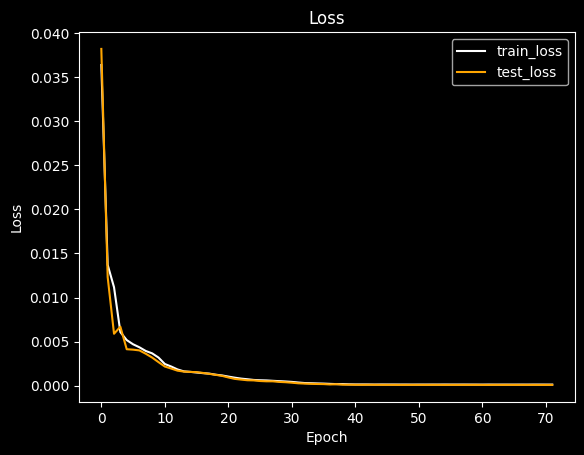

In [115]:
plt.style.use("dark_background")
x = range(len(train_loss_lstm))
plt.plot(x, train_loss_lstm, label='train_loss', color='white')
plt.plot(x, test_loss_lstm, label='test_loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

In [116]:
best_model = torch.load("best_val_model_ 0.000096.pth", weights_only=False)

In [117]:
def inference_lstm(model, src, device, max_len=15):
    model.eval()
    
    with torch.no_grad():
        src_len = torch.tensor([src.shape[0]]).cpu()
        
        src_packed = torch.nn.utils.rnn.pack_padded_sequence(
            src, src_len, batch_first=False, enforce_sorted=False
        )
        
        _, (hidden, cell) = model.encoder(src_packed)
        
        decoder_input = torch.zeros(1, 1, 4).to(device)
        
        predictions = []
        
        for _ in range(max_len):
            decoder_output, (hidden, cell) = model.decoder(decoder_input, (hidden, cell))
            
            pred = model.output(decoder_output) # (1, 1, 4)
            
            predictions.append(pred)
            а
            decoder_input = pred
            
        return torch.cat(predictions, dim=0)


batch = next(iter(test_loader))
src_batch, _, tgt_out_batch, src_pad_batch, _, _ = batch

idx = 3
src_sample = src_batch[:, idx, :].unsqueeze(1).to(device)
tgt_sample = tgt_out_batch[:, idx, :].to(device)

src_pad_sample = src_pad_batch[idx, :]
real_src_len = (~src_pad_sample).sum().item()
src_sample = src_sample[:real_src_len]

predicted_seq = inference_lstm(best_model, src_sample, device, max_len=tgt_sample.shape[0])

print(f"{'Frame':<5} | {'Predicted (xc, yc, w, h)':<40} | {'True Target (xc, yc, w, h)'}")
print("-" * 85)

for i in range(len(predicted_seq)):
    pred_vals = predicted_seq[i, 0].cpu().numpy()
    true_vals = tgt_sample[i].cpu().numpy()
    
    p_str = f"[{pred_vals[0]:.2f}, {pred_vals[1]:.2f}, {pred_vals[2]:.2f}, {pred_vals[3]:.2f}]"
    t_str = f"[{true_vals[0]:.2f}, {true_vals[1]:.2f}, {true_vals[2]:.2f}, {true_vals[3]:.2f}]"
    
    print(f"{i:<5} | {p_str:<40} | {t_str}")


loss_val = torch.nn.SmoothL1Loss()(predicted_seq, tgt_sample.unsqueeze(1))
print(f"\nTest Sample Loss: {loss_val.item():.4f}")


Frame | Predicted (xc, yc, w, h)                 | True Target (xc, yc, w, h)
-------------------------------------------------------------------------------------
0     | [0.53, 0.43, 0.40, 0.55]                 | [0.58, 0.44, 0.43, 0.58]
1     | [0.57, 0.44, 0.41, 0.58]                 | [0.58, 0.43, 0.47, 0.62]
2     | [0.57, 0.44, 0.41, 0.58]                 | [0.58, 0.43, 0.47, 0.63]
3     | [0.57, 0.44, 0.41, 0.58]                 | [0.60, 0.43, 0.42, 0.56]
4     | [0.57, 0.44, 0.41, 0.58]                 | [0.60, 0.43, 0.42, 0.56]
5     | [0.57, 0.44, 0.41, 0.58]                 | [0.60, 0.43, 0.40, 0.53]
6     | [0.57, 0.44, 0.42, 0.58]                 | [0.60, 0.40, 0.34, 0.46]
7     | [0.57, 0.44, 0.42, 0.58]                 | [0.61, 0.41, 0.36, 0.47]
8     | [0.57, 0.44, 0.42, 0.58]                 | [0.61, 0.41, 0.34, 0.46]
9     | [0.57, 0.44, 0.42, 0.58]                 | [0.61, 0.42, 0.36, 0.48]
10    | [0.57, 0.44, 0.42, 0.58]                 | [0.59, 0.43, 0.36, 0.48]


In [119]:
optimizer_lstm2 = optim.Adam(best_model.parameters(),
                       lr=1e-5)
scheduler_lstm2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_lstm2, 
    mode='min', 
    factor=0.8,     
    patience=3
)
train_loss_lstm, test_loss_lstm = train_test_lstm(best_model, 
                                   train_loader, 
                                   test_loader, 
                                   masked_loss, 
                                   optimizer_lstm2,
                                   scheduler_lstm2,
                                   50) 

[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.04s/it]

[EPOCHS]:   2%|█▍                                                                     | 1/50 [01:31<1:14:32, 91.27s/it]

(1/50): train_lss -  0.000136, test_lss -  0.000109
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:25<00:00, 14.30s/it]

[EPOCHS]:   4%|██▊                                                                    | 2/50 [03:06<1:14:47, 93.49s/it]

(2/50): train_lss -  0.000137, test_lss -  0.000105
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:33<00:00, 15.66s/it]

[EPOCHS]:   6%|████▎                                                                  | 3/50 [04:50<1:16:59, 98.30s/it]

(3/50): train_lss -  0.000135, test_lss -  0.000099
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.94s/it]

[EPOCHS]:   8%|█████▋                                                                 | 4/50 [06:23<1:13:50, 96.32s/it]

(4/50): train_lss -  0.000138, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:25<00:00, 14.23s/it]

[EPOCHS]:  10%|███████                                                                | 5/50 [07:59<1:12:04, 96.10s/it]

(5/50): train_lss -  0.000137, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.01s/it]

[EPOCHS]:  12%|████████▌                                                              | 6/50 [09:42<1:12:16, 98.56s/it]

(6/50): train_lss -  0.000134, test_lss -  0.000097
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [03:12<00:00, 32.04s/it]

[EPOCHS]:  14%|█████████▊                                                            | 7/50 [13:08<1:35:46, 133.63s/it]

(7/50): train_lss -  0.000136, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:39<00:00, 16.58s/it]

[EPOCHS]:  16%|███████████▏                                                          | 8/50 [15:08<1:30:32, 129.34s/it]

(8/50): train_lss -  0.000135, test_lss -  0.000097



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:37<00:00, 16.28s/it]

[EPOCHS]:  18%|████████████▌                                                         | 9/50 [17:04<1:25:27, 125.06s/it]

(9/50): train_lss -  0.000134, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:29<00:00, 14.95s/it]

[EPOCHS]:  20%|█████████████▊                                                       | 10/50 [18:54<1:20:16, 120.42s/it]

(10/50): train_lss -  0.000130, test_lss -  0.000093
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:32<00:00, 15.49s/it]

[EPOCHS]:  22%|███████████████▏                                                     | 11/50 [20:48<1:16:56, 118.38s/it]

(11/50): train_lss -  0.000131, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:31<00:00, 15.32s/it]

[EPOCHS]:  24%|████████████████▌                                                    | 12/50 [22:33<1:12:25, 114.35s/it]

(12/50): train_lss -  0.000133, test_lss -  0.000097



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.76s/it]

[EPOCHS]:  26%|█████████████████▉                                                   | 13/50 [24:23<1:09:47, 113.17s/it]

(13/50): train_lss -  0.000136, test_lss -  0.000099



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:26<00:00, 14.41s/it]

[EPOCHS]:  28%|███████████████████▎                                                 | 14/50 [26:09<1:06:35, 110.98s/it]

(14/50): train_lss -  0.000132, test_lss -  0.000098



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:26<00:00, 14.36s/it]

[EPOCHS]:  30%|████████████████████▋                                                | 15/50 [27:55<1:03:46, 109.32s/it]

(15/50): train_lss -  0.000136, test_lss -  0.000102



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:26<00:00, 14.45s/it]

[EPOCHS]:  32%|██████████████████████                                               | 16/50 [29:33<1:00:08, 106.12s/it]

(16/50): train_lss -  0.000133, test_lss -  0.000105



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:29<00:00, 14.97s/it]

[EPOCHS]:  34%|████████████████████████▏                                              | 17/50 [31:15<57:37, 104.76s/it]

(17/50): train_lss -  0.000135, test_lss -  0.000098



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:22<00:00, 13.79s/it]

[EPOCHS]:  36%|█████████████████████████▌                                             | 18/50 [32:50<54:20, 101.90s/it]

(18/50): train_lss -  0.000135, test_lss -  0.000105



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:37<00:00, 16.29s/it]

[EPOCHS]:  38%|██████████████████████████▉                                            | 19/50 [34:41<53:59, 104.51s/it]

(19/50): train_lss -  0.000132, test_lss -  0.000098



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:33<00:00, 15.52s/it]

[EPOCHS]:  40%|████████████████████████████▍                                          | 20/50 [36:31<53:09, 106.31s/it]

(20/50): train_lss -  0.000132, test_lss -  0.000093
Model with best loss saved



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00, 18.57s/it]

[EPOCHS]:  42%|█████████████████████████████▊                                         | 21/50 [38:37<54:16, 112.29s/it]

(21/50): train_lss -  0.000135, test_lss -  0.000102



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:43<00:00, 17.19s/it]

[EPOCHS]:  44%|███████████████████████████████▏                                       | 22/50 [40:35<53:07, 113.85s/it]

(22/50): train_lss -  0.000132, test_lss -  0.000096



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:43<00:00, 17.25s/it]

[EPOCHS]:  46%|████████████████████████████████▋                                      | 23/50 [42:37<52:24, 116.45s/it]

(23/50): train_lss -  0.000133, test_lss -  0.000095



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:36<00:00, 16.01s/it]

[EPOCHS]:  48%|██████████████████████████████████                                     | 24/50 [44:32<50:10, 115.78s/it]

(24/50): train_lss -  0.000134, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:45<00:00, 17.62s/it]

[EPOCHS]:  50%|███████████████████████████████████▌                                   | 25/50 [46:31<48:43, 116.95s/it]

(25/50): train_lss -  0.000134, test_lss -  0.000101



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.77s/it]

[EPOCHS]:  52%|████████████████████████████████████▉                                  | 26/50 [48:26<46:33, 116.40s/it]

(26/50): train_lss -  0.000131, test_lss -  0.000102



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:28<00:00, 14.80s/it]

[EPOCHS]:  54%|██████████████████████████████████████▎                                | 27/50 [50:16<43:51, 114.42s/it]

(27/50): train_lss -  0.000131, test_lss -  0.000100



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:30<00:00, 15.05s/it]

[EPOCHS]:  56%|███████████████████████████████████████▊                               | 28/50 [51:59<40:43, 111.06s/it]

(28/50): train_lss -  0.000131, test_lss -  0.000095



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:30<00:00, 15.10s/it]

[EPOCHS]:  58%|█████████████████████████████████████████▏                             | 29/50 [53:51<38:58, 111.36s/it]

(29/50): train_lss -  0.000132, test_lss -  0.000099



[train]: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:35<00:00, 15.96s/it]

[EPOCHS]:  58%|█████████████████████████████████████████▏                             | 29/50 [55:40<40:19, 115.20s/it]

(30/50): train_lss -  0.000135, test_lss -  0.000095


In [120]:
best_model_lstm = torch.load("best_val_model_ 0.000093.pth", weights_only=False)

In [124]:

batch = next(iter(train_loader))
src_batch, _, tgt_out_batch, src_pad_batch, _, _ = batch


idx = 4
src_sample = src_batch[:, idx, :].unsqueeze(1).to(device)
tgt_sample = tgt_out_batch[:, idx, :].to(device)


src_pad_sample = src_pad_batch[idx, :]
real_src_len = (~src_pad_sample).sum().item()
src_sample = src_sample[:real_src_len]


predicted_seq = inference_lstm(best_model_lstm, src_sample, device, max_len=tgt_sample.shape[0])

# (xc, yc, w, h)
print(f"{'Frame':<5} | {'Predicted (xc, yc, w, h)':<40} | {'True Target (xc, yc, w, h)'}")
print("-" * 85)

for i in range(len(predicted_seq)):
    pred_vals = predicted_seq[i, 0].cpu().numpy()
    true_vals = tgt_sample[i].cpu().numpy()
    

    p_str = f"[{pred_vals[0]:.2f}, {pred_vals[1]:.2f}, {pred_vals[2]:.2f}, {pred_vals[3]:.2f}]"
    t_str = f"[{true_vals[0]:.2f}, {true_vals[1]:.2f}, {true_vals[2]:.2f}, {true_vals[3]:.2f}]"
    
    print(f"{i:<5} | {p_str:<40} | {t_str}")


loss_val = torch.nn.SmoothL1Loss()(predicted_seq, tgt_sample.unsqueeze(1))
print(f"\nTest Sample Loss: {loss_val.item():.4f}")

Frame | Predicted (xc, yc, w, h)                 | True Target (xc, yc, w, h)
-------------------------------------------------------------------------------------
0     | [0.35, 0.32, 0.15, 0.19]                 | [0.34, 0.33, 0.14, 0.21]
1     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.21]
2     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.15, 0.22]
3     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.20]
4     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.21]
5     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.20]
6     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.20]
7     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.21]
8     | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.20]
9     | [0.36, 0.33, 0.15, 0.20]                 | [0.35, 0.33, 0.14, 0.20]
10    | [0.36, 0.33, 0.15, 0.20]                 | [0.34, 0.33, 0.14, 0.20]


In [4]:
!python --version

Python 3.11.5
